# Imports

In [1]:
import matplotlib.pyplot as plt
import torch

from torch.linalg import pinv, svd
from torch.utils.data import WeightedRandomSampler

# Definition of the function

In [2]:
def get_approx_G(G, c, k):
    """
    Return the approximation of a Gram matrix G.
    """
    
    # Check the dimensions
    assert 0 <= k <= c <= len(G)
    
    # Compute the weights
    weights = torch.diag(G).pow(2)
    weights = weights / weights.sum()
    
    # Sample the indices
    idx = list(WeightedRandomSampler(weights=weights, num_samples=c, replacement=False))
    coefs = torch.sqrt(c * weights[idx])
    
    # Construct the matrices
    C = G[:, idx] / coefs
    W = C[idx, :] / coefs.unsqueeze(1)
    
    # Find the SVD decomposition
    U, S, Vh = svd(W)
    
    # Find the best rank-k approximation
    Wk = sum(S[i] * torch.outer(U[:, i], Vh[i, :]) for i in range(k))
    
    # Compute the generalized inverse
    Wk_plus = pinv(Wk)
    
    # Compute the final approximation
    Gk_approx = torch.mm(C, torch.mm(Wk_plus, torch.t(C)))
    
    return Gk_approx

# Example

In [3]:
torch.manual_seed(0)

d = 200
c_ = list(range(100, d + 1))
n_samples = len(c_)

loss = torch.nn.MSELoss(reduction="mean")

error = []
best_error = []

for c in c_:
    X = torch.rand(d, d)
    G = torch.mm(X, torch.t(X))
    
    # Find rank-k approximation
    k = c // 2
    Gk_approx = get_approx_G(G, c, k)
    error.append(loss(Gk_approx, G))
    
    # Find best rank-k approximation
    U, S, Vh = svd(G)
    Gk = sum(S[i] * torch.outer(U[:, i], Vh[i, :]) for i in range(k))
    best_error.append(loss(Gk, G))

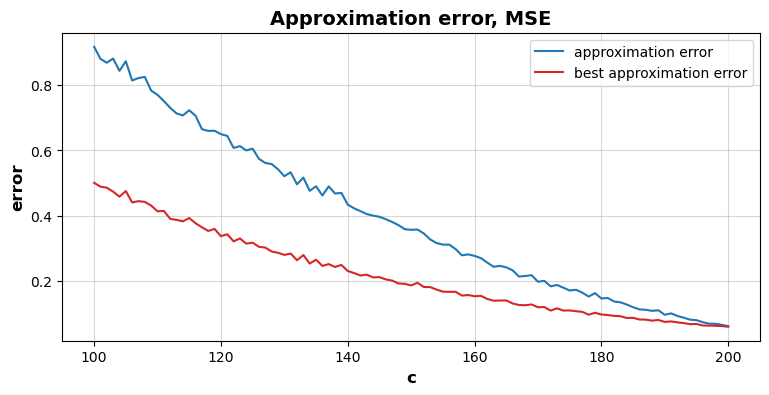

In [4]:
plt.figure(figsize=(9, 4))
plt.plot(c_, error, color="tab:blue", label="approximation error")
plt.plot(c_, best_error, color="tab:red", label="best approximation error")
plt.grid(alpha=0.5)
plt.xlabel("c", fontdict={"size":12, "weight":"bold"})
plt.ylabel("error", fontdict={"size":12, "weight":"bold"})
plt.title("Approximation error, MSE", fontdict={"size":14, "weight":"bold"})
plt.legend()
plt.show()